# Required Installations of Spark & Jave and set up of Environment Variables.

In [1]:
import os
# Find the latest version of spark 3.2 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.2.3'
spark_version = 'spark-3.2.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()



Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [102 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com

In [2]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.5.1.jar

--2023-01-05 21:06:05--  https://jdbc.postgresql.org/download/postgresql-42.5.1.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1046770 (1022K) [application/java-archive]
Saving to: ‘postgresql-42.5.1.jar’

postgresql-42.5.1.j 100%[===================>]   1022K  5.59MB/s    in 0.2s    

2023-01-05 21:06:06 (5.59 MB/s) - ‘postgresql-42.5.1.jar’ saved [1046770/1046770]



# Load Amazon Data into Spark DataFrame
## Get the Country latitude and longitude details with GDP

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("FinalProject-WomenWellBeing").config("spark.driver.extraClassPath","/content/postgresql-42.5.1.jar").getOrCreate()


In [4]:
from pyspark import SparkFiles
url = "https://womenwellbeing.s3.us-west-1.amazonaws.com/Livwell_in_interpolated.csv"
spark.sparkContext.addFile(url)

livewell_df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("Livwell_in_interpolated.csv"), sep=",", header=True, inferSchema=True)
livewell_df.show()


+------------+------------+----+---------------------+----------------------+---------+-------------------+--------------------+------------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+--------------+-----------------+----------------+-------------------+-----------+--------------+---------------+------------------+---------+------------+-------------+----------------+----------+-------------+-------------------------+-------------------------+-------------------------+---------------------------+---------------------------+---------------------------+-------------------------+-------------------------+-------------------------+-----------------------+--------------------------+---------------------------------+------------------------------------+-----------------------+--------------------------+-------------------------------

### Load the dataframe with required columns and clean the data.

In [5]:
livewell_orginal_df =livewell_df
livewell_df.summary().show()




+-------+------------+------------+------------------+---------------------+----------------------+---------+-------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------------+-------------------------+-------------------------+---------------------------+---------------------------+---------------------------+-------------------------+-------------------------+-------------------------+-----------------------+--------------------------+---------------------------------+-----------

## Convert PySpark dataframe to pandas data frame for etl process.

In [6]:
import pandas as pd

livewell_etl_df = livewell_df.toPandas()


livewell_etl_df

/content/spark-3.2.3-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


,country_name,country_code,year,region_num_harmonized,region_name_harmonized,SurveyId,interview_year_mean,interview_month_mean,CMC_interview_mean,DM_age_15.19_p,...,EI_computer_p,EI_computer_p_se,DP_decide_no_contraception_p,DP_decide_no_contraception_p_se,EI_internet_day_p,EI_internet_day_p_se,EI_internet_week_p,EI_internet_week_p_se,EI_mobile_p,EI_mobile_p_se
0,Colombia,COL,1990,1,Atlantica,CO1990DHS,1990,7,1086.75,21.52,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,Colombia,COL,1990,2,Oriental,CO1990DHS,1990,7,1086.93,22.84,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,Colombia,COL,1990,3,Central,CO1990DHS,1990,7,1086.76,19.49,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Colombia,COL,1990,4,Pacifica,CO1990DHS,1990,7,1086.59,21.86,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Colombia,COL,1990,5,Bogota,CO1990DHS,1990,5,1085.41,19.51,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7365,Senegal,SEN,2019,4,Kolda + Ziguinchor + Sedhiou (South),SN2019DHS,2019,8,1435.61,24.41,...,10.67,2.09,76.89,2.18,13.12,1.77,23.3,2.13,55.54,2.54
7366,Sierra Leone,SLE,2019,1,Eastern,SL2019DHS,2019,7,1434.66,21.11,...,2.06,0.34,44.78,2.5,3.01,0.5,5.56,0.62,33.34,1.65
7367,Sierra Leone,SLE,2019,2,Northern + North Western,SL2019DHS,2019,7,1434.77,22.77,...,2.36,0.3,52.67,2.31,3.43,0.41,5.44,0.54,34.53,1.36
7368,Sierra Leone,SLE,2019,3,Southern,SL2019DHS,2019,7,1434.62,21.73,...,2.33,0.36,63.38,2.04,5.5,0.5,7.19,0.66,32.44,1.54


### Drop the unnecessary columns and drop the null values and store the clean data into a new dataframe.

In [7]:
livewell_etl_df =livewell_etl_df.dropna()
livewell_etl_df = livewell_etl_df.drop(columns=['region_num_harmonized','region_name_harmonized','SurveyId','interview_year_mean','interview_month_mean','CMC_interview_mean'],axis=1)
livewell_etl_df.columns

Index(['country_name', 'country_code', 'year', 'DM_age_15.19_p',
       'DM_age_15.19_p_se', 'DM_age_20.24_p', 'DM_age_20.24_p_se',
       'DM_age_25.29_p', 'DM_age_25.29_p_se', 'DM_age_30.34_p',
       ...
       'EI_computer_p', 'EI_computer_p_se', 'DP_decide_no_contraception_p',
       'DP_decide_no_contraception_p_se', 'EI_internet_day_p',
       'EI_internet_day_p_se', 'EI_internet_week_p', 'EI_internet_week_p_se',
       'EI_mobile_p', 'EI_mobile_p_se'],
      dtype='object', length=401)

In [8]:
livewell_etl_df = livewell_etl_df.loc[livewell_etl_df['year']>= 2000]
livewell_etl_df.describe()

,year,DM_age_15.19_p_se,DM_age_20.24_p_se,DM_age_25.29_p_se,DM_age_30.34_p_se,DM_age_35.39_p_se,DM_age_40.44_p_se,DM_age_45.49_p_se,DM_age_mean_se,DM_marr_p_se,...,HD_women_size_mean_se,RH_age_first_birth_mean_se,RH_children_born_mean_se,RH_children_living_mean_se,RH_contr_modern_p_se,RH_contr_p_se,WL_wealth_gini,WL_wealth_mean,WL_wealth_mean_se,WL_wealth_median
count,5967.000000,5967.000000,5967.00000,5967.000000,5967.000000,5967.000000,5967.000000,5967.000000,5967.000000,5967.000000,...,5967.000000,5967.000000,5967.000000,5967.000000,5967.000000,5967.000000,5967.000000,5967.000000,5967.000000,5967.000000
mean,2007.827216,1.243674,1.23557,1.239853,1.150581,1.063693,0.969010,0.908726,0.399548,2.039871,...,0.205679,0.200339,0.098391,0.083638,1.648565,1.814009,0.388251,37.482163,1.472722,35.318112
std,4.755202,0.576403,0.48798,0.463376,0.411243,0.381618,0.374867,0.355795,0.329291,0.918258,...,0.168454,0.068502,0.043146,0.035574,0.786308,0.838177,0.120432,19.072721,0.706807,21.552352
min,2000.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068053,6.200000,0.170000,0.000000
25%,2004.000000,0.876000,0.92000,0.935167,0.877321,0.808000,0.718000,0.660000,0.240312,1.479286,...,0.120000,0.151339,0.070000,0.060000,1.140000,1.300000,0.305333,21.775000,0.965357,17.105000
50%,2008.000000,1.226667,1.18200,1.184000,1.104000,1.020000,0.920000,0.865000,0.312222,1.880000,...,0.164000,0.195000,0.092500,0.080000,1.540833,1.695000,0.392078,34.280000,1.395000,30.266000
75%,2012.000000,1.557750,1.46775,1.457321,1.360000,1.262678,1.141833,1.090000,0.407321,2.370000,...,0.239286,0.240000,0.120000,0.100000,2.000000,2.168000,0.461980,51.597290,1.866334,52.370000
max,2019.000000,7.924000,6.15400,6.020000,4.656000,4.016000,4.756000,3.918000,4.620000,13.100000,...,3.130000,0.590000,0.500000,0.460000,13.420000,13.140000,0.949653,88.110000,6.760000,88.690000


In [9]:

df = livewell_etl_df
mean_cols = list(df.columns[df.columns.str.endswith('_mean')])
mean_cols.insert(0,'year') 
mean_cols.insert(1,'country_name') 
mean_cols

df[mean_cols]
output = df.groupby(['year','country_name'])[mean_cols]
# livewell_etl_df[mean_cols]
output.first()

year  country_name DM_age_marr_mean DM_age_mean  \
year country_name                                                    
2000 Armenia       2000       Armenia            19.99       30.71   
     Bangladesh    2000    Bangladesh             14.9       25.63   
     Benin         2000         Benin           17.224       29.11   
     Bolivia       2000       Bolivia           20.358      29.076   
     Cambodia      2000      Cambodia            18.98       29.46   
...                 ...           ...              ...         ...   
2018 Senegal       2018       Senegal            21.29        28.9   
     Sierra Leone  2018  Sierra Leone         18.15667       29.25   
     Zambia        2018        Zambia            18.36       27.95   
2019 Senegal       2019       Senegal            20.88       28.99   
     Sierra Leone  2019  Sierra Leone             18.3       29.29   

                  ED_educ_years_mean FP_desired_mean  HD_children_mean  \
year country_name                                                        
2000 Armenia                   10.85            2.82             0.510   
     Bangladesh                  3.2            2.12             0.740   
     Benin                     0.956           6.412             1.394   
     Bolivia                   6.952           2.408             0.734   
     Cambodia                   2.63            3.64             0.800   
...                              ...             ...               ...   
2018 Senegal                    6.31            4.77             1.170   
     Sierra Leone           3.806667        4.878333             0.975   
     Zambia                     7.44            4.74             0.910   
2019 Senegal                    5.77            4.93             1.080   
     Sierra Leone               3.99            4.86             0.940   

                  HD_size_defacto_mean  HD_size_dejure_mean  \
year country_name                                             
2000 Armenia                      4.65                5.020   
     Bangladesh                   4.97                5.160   
     Benin                       6.082                6.278   
     Bolivia                     4.182                4.296   
     Cambodia                     5.14                5.240   
...                                ...                  ...   
2018 Senegal                      7.55                7.410   
     Sierra Leone             5.231667                5.350   
     Zambia                       4.98                5.050   
2019 Senegal                      7.21                7.160   
     Sierra Leone                 5.16                5.300   

                  HD_women_children_mean  ... HH_women_time_water_mean  \
year country_name                         ...                            
2000 Armenia                        0.67  ...                     18.9   
     Bangladesh                      0.7  ...              12.33529412   
     Benin                         1.976  ...                       NA   
     Bolivia                       0.958  ...                   20.252   
     Cambodia                       0.86  ...                    11.03   
...                                  ...  ...                      ...   
2018 Senegal                        1.78  ...                    22.47   
     Sierra Leone                  1.225  ...                    23.35   
     Zambia                         1.27  ...                    22.46   
2019 Senegal                        1.76  ...                    16.92   
     Sierra Leone                   1.18  ...                    23.96   

                  RH_age_first_birth_mean RH_age_first_sex_mean  \
year country_name                                                 
2000 Armenia                        21.66                 20.49   
     Bangladesh                     17.28                    NA   
     Benin                         19.064                16.584   
     Bolivia               

## Find the dependant features for the unsupervised learning and predict

In [10]:
!pip install Scikit-learn
!pip install sklearn
!pip install plotly
!pip install hvplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=fcb841a02e844b7aa68fa1be09f96b303d491bb9bbae1228134328cb37ed189a
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 65.3 MB/s eta 0:00:00


In [21]:
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas

ML_original_df = output.first().copy()
# Use get_dummies() to create variables for text features.
ML_original_df =ML_original_df.drop(columns='country_name')
ML_original_df =ML_original_df.drop(columns='year')
ML_original_df = ML_original_df.reset_index()
# ML_original_df = ML_original_df.set_index('country_name')
ML_features_df = pd.get_dummies(ML_original_df)
print(ML_features_df.shape)
ML_features_df



(666, 9294)


,year,HD_children_mean,HD_size_dejure_mean,WL_wealth_mean,country_name_Armenia,country_name_Bangladesh,country_name_Benin,country_name_Bolivia,country_name_Burkina Faso,country_name_Burundi,...,HL_number_cigarettes_mean_9.752857,HL_number_cigarettes_mean_9.816923,HL_number_cigarettes_mean_9.852,HL_number_cigarettes_mean_9.873333,HL_number_cigarettes_mean_9.912,HL_number_cigarettes_mean_9.916,HL_number_cigarettes_mean_9.95,HL_number_cigarettes_mean_9.988571,HL_number_cigarettes_mean_99,HL_number_cigarettes_mean_NA
0,2000,0.510,5.020,55.01000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2000,0.740,5.160,29.88000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2000,1.394,6.278,16.78400,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2000,0.734,4.296,40.60800,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2000,0.800,5.240,27.98000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,2018,1.170,7.410,71.21000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
662,2018,0.975,5.350,18.33333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
663,2018,0.910,5.050,28.82000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
664,2019,1.080,7.160,69.01000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Apply standard scalar to fit and transform

In [22]:

# Creating the scaler instance
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()
ML_scaled_df = data_scaler.fit_transform(ML_features_df)
ML_scaled_df[:5]

array([[-1.66527087, -0.9716581 ,  0.20740932, ..., -0.03877834,
        -0.05488213,  1.07162825],
       [-1.66527087, -0.16522007,  0.35039623, ..., -0.03877834,
        -0.05488213,  1.07162825],
       [-1.66527087,  2.12786893,  1.49224886, ..., -0.03877834,
        -0.05488213,  1.07162825],
       [-1.66527087, -0.18625759, -0.53203728, ..., -0.03877834,
        -0.05488213,  1.07162825],
       [-1.66527087,  0.04515507,  0.43210304, ..., -0.03877834,
        -0.05488213, -0.93315943]])

## Feature reduction using PCA

In [23]:
# Using PCA to reduce dimension to three principal components.
# Initialize PCA model
pca = PCA(n_components=3)
# Get two principal components for the iris data.
ML_pca = pca.fit_transform(ML_scaled_df)
ML_pca

array([[-0.31319167,  1.33746528,  1.69378726],
       [ 1.99782107, -0.18042752,  0.1482446 ],
       [-1.26523851, -2.09438137,  0.47293835],
       ...,
       [ 0.40835776,  1.46732327, -2.10506552],
       [-0.36449094,  0.50804851, -0.11894402],
       [-2.32747169, -1.188944  , -1.76773708]])

In [24]:
# Create a DataFrame with the three principal components.
# YOUR CODE HERE
ML_pca_df = pd.DataFrame(data=ML_pca,
columns={'PCA1','PCA2','PCA3'})
ML_pca_df =ML_pca_df.set_index(ML_original_df.index)
ML_pca_df

,PCA1,PCA3,PCA2
0,-0.313192,1.337465,1.693787
1,1.997821,-0.180428,0.148245
2,-1.265239,-2.094381,0.472938
3,2.333228,-2.264655,-2.042462
4,-3.036612,-0.389708,2.957750
...,...,...,...
661,-2.980450,0.308384,0.581795
662,-11.796773,-2.477117,4.832163
663,0.408358,1.467323,-2.105066
664,-0.364491,0.508049,-0.118944


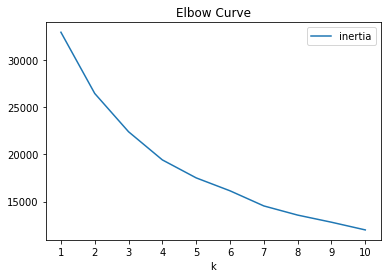

In [25]:
# Create an elbow curve to find the best value for K.
# Find the best value for K

from sklearn.cluster import KMeans
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of K values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(ML_pca_df)
    inertia.append(km.inertia_)


# Create the elbow curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

df_elbow.plot(x="k", y="inertia", xticks=k, title="Elbow Curve")
# plot = df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")
# plot
# df_elbow

In [26]:
# Initialize the K-Means model.
# YOUR CODE HERE
model = KMeans(n_clusters=6, random_state=5)
# Fit the model
# YOUR CODE HERE
model.fit(ML_pca_df)
# Predict clusters
# YOUR CODE HERE
predictions = model.predict(ML_pca_df)


len(predictions)

666

In [47]:
# clustered_df =pd.concat([crypto_original_df,crypto_pca_df], on ='Unnamed: 0')
clustered_df = ML_original_df.join(ML_pca_df)

clustered_df['Class'] = predictions
# # Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(10)


spark_df = spark.createDataFrame(clustered_df)
spark_df.show()



(666, 26)


In [31]:
# Creating a 3D-Scatter with the PCA data and the clusters
fig = px.scatter(
    clustered_df,
    x="",
    y="PCA2",
    z="PCA3",
    color="Class",
    symbol="Class",
    hover_name="country_name",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [65]:
# ED_educ_years_mean	FP_desired_mean

# clustered_df.plot(kind='scatter',
#     x="ED_educ_years_mean",
#     y="FP_desired_mean",
#     hover_cols=["country_name"],
#     by="Class",
#     color=["#0C0E92", "#ECCA1F","#33F6FF","#FF5733"],
# )
clustered_df[['country_name','DM_age_mean','ED_educ_years_mean']].groupby(['country_name']).first()

,DM_age_mean,ED_educ_years_mean
country_name,,
Armenia,30.71,10.85
Bangladesh,25.63,3.2
Benin,29.11,0.956
Bolivia,29.076,6.952
Burkina Faso,30.69,0.97
Burundi,26.09,7.69
Cambodia,29.46,2.63
Cameroon,27.39,8
Colombia,29.43,7.96
